# Groverのアルゴリズムを用いた充足可能性問題の解法

このセクションでは、Qiskit Aqua内のGroverのアルゴリズムの実装を用いた、充足可能性問題の解法を説明します。  

## 目次

1. [序論](#introduction)

2. [3-SAT問題](#3satproblem)

3. [Qiskitでの実装](#implementation)

4. [演習問題](#problems)

5. [参考文献](#references)

## 1. 序論 <a id='introduction'></a>

[前のセクション](../ch-algorithms/grover.ipynb)では、非構造化探索に対するGroverのアルゴリズムについて、Qiskit Terraを用いた例と実装とともに紹介しました。Groverの探索は、古典的なコンピューターのものより二乗のオーダーで、早く正しい解を探すことができる量子アルゴリズムであることがお分かりいただけたと思います。ここでは、Groverのアルゴリズムを使用して、組合せブール値の充足可能性問題の解法を説明しましょう。

コンピューター・サイエンスにおいて、ブール値の充足性問題とは、与えられたブール式を満たす解が存在するかどうかを決定する問題です。言い換えると、式がTRUEと評価されるように、与えられたブール式の変数をTRUEまたはFALSEの値で置き換えることができるかどうかを問う問題になります。置き換えられる場合、式は「充足している」と言います。 一方、そのような値の割り当てが存在しない場合は、式で表される関数は、すべての可能な変数値に対してFALSEになり、式は「充足していない」と言います。 つまり、ブール式を満たす割り当てを解とすると、これは探索問題と見なすことができます。

## 2. 3-SAT問題  <a id='3satproblem'></a>

3体充足度問題（3-SAT問題）は、次の具体的な問題が最良の説明となります。以下の様に、3つのブール変数 $v_1,v_2,v_3$ とブール関数 $f$ を考えましょう：

$$f(v_1,v_2,v_3) = (\neg v_1 \vee \neg v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee v_3) \wedge (v_1 \vee v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee \neg v_3) \wedge (\neg v_1 \vee v_2 \vee v_3)$$

上の関数において、右側の方程式の項の$()$の内側を、節と呼びます。つまり、この関数には5つの節があります。3-SAT問題であるため、各節には必ず3つのリテラルがあります。 例えば、最初の節には、 $ \neg v_1$、 $\neg v_2$ 、および $\neg v_3$ がリテラルとして含まれています。 記号 $\neg$ は、後続のリテラルの値を否定する（または反転する）論理NOTです。 記号 $\vee$ と $\wedge$  は、それぞれ論理ORと論理ANDになります。 $f(v_1, v_2, v_3) = 1$ と評価できる $v_1, v_2, v_3$ の値がある場合には、ブール関数 $f$ は充足します（つまり、 $f$ がTrueと評価できるということです）。

そのような値を見つけるための馬鹿正直な方法は、$f$の入力値の可能なすべての組み合わせを試行することです。以下の表は、 $v_1, v_2, v_3$ のすべての可能な組み合わせを試行した時に得られる表です。 説明を容易にするため、 $0$ はFalseと、 $1$ はTrueと同義とします。

|$v_1$ | $v_2$ | $v_3$ | $f$ | コメント | 
|------|-------|-------|-----|---------|
| 0    |  0    |  0    |  1  | **解** | 
| 0    |  0    |  1    |  0  | $f$ がFalseなので解ではない | 
| 0    |  1    |  0    |  0  | $f$ がFalseなので解ではない | 
| 0    |  1    |  1    |  0  | $f$ がFalseなので解ではない | 
| 1    |  0    |  0    |  0  | $f$ がFalseなので解ではない | 
| 1    |  0    |  1    |  1  | **解** | 
| 1    |  1    |  0    |  1  | **解** | 
| 1    |  1    |  1    |  0  | $f$ がFalseなので解ではない | 

上の表から、この3-SAT問題が、3つの充足解 $(v_1, v_2, v_3) = (T, F, T)$ or $(F, F, F)$ or $(T, T, F)$ を持つことがわかります。

一般的に、ブール関数 $f$ は、多くの節と、より多くのブール型変数を持ちます。3-SAT問題は、連言標準形（Conjunctive Normal Form、CNF)、つまり3つのリテラルの選言からなる節と一つ以上の節の連言として常に表現できることに注意してください。すなわち、3つの論理和の論理積となります。

## 3. Qiskitでの実装 <a id='implementation'></a>

では、Qiskit Aquaを使って、3-SATの例題を解いてみましょう: 
$$f(v_1,v_2,v_3) = (\neg v_1 \vee \neg v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee v_3) \wedge (v_1 \vee v_2 \vee \neg v_3) \wedge (v_1 \vee \neg v_2 \vee \neg v_3) \wedge (\neg v_1 \vee v_2 \vee v_3)$$

まず、Qiskit Aquaがこの様な問題を解くために使用している入力フォーマット [DIMACS CNF](http://www.satcompetition.org/2009/format-benchmarks2009.html) ついて理解する必要があります：
	
~~~
c example DIMACS CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
~~~

- `c` から始まる行はコメントです
    - 例： `c example DIMACS CNF 3-SAT`
- 最初の非コメント行は、`p cnf nbvar nbclauses` という形である必要があります。ここで：
  - `cnf` は、入力がCNF形式であることを意味します
  - `nbvar` は、ファイル内に出現する変数の正確な数です
  - `nbclauses` は、ファイル内に含まれる節の正確な数です
  - 例： `p cnf 3 5`
- 次に、各節の行が記述されます。ここで：
  - 各節は `-nbvar` から `nbvar`の間の個別の非Null値の数列で、行は`0`で終わります
  - 反数 i と -i を同時に含むことはできません
  - 正の数は対応する変数を意味します
  - 負の数は対応する変数の否定を意味します
  - 例：`-1 2 3 0` は、節 $\neg v_1 \vee v_2 \vee v_3$ に対応します。

同様に、前の問題の解 $(v_1, v_2, v_3) = (T, F, T)$ , $(F, F, F)$ , $(T, T, F)$ は、`1 -2 3` , `-1 -2 -3` , `1 2 -3` と書くことができます.

この例題を入力として、Grover探索に対応する Oracle を作成します。具体的には、Aquaで提供されるLogicalExpressionOracleコンポーネントを使用します。このコンポーネントは、DIMACS CNF構文文字列の解析と、対応するOracle回路の構築をサポートしています。

In [1]:
import numpy as np
from qiskit import BasicAer
from qiskit.visualization import plot_histogram
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
from qiskit.aqua import QuantumInstance, run_algorithm
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle, TruthTableOracle

In [2]:
input_3sat = '''
c example DIMACS-CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 -2 3 0
1 2 -3 0
1 -2 -3 0
-1 2 3 0
'''

In [3]:
oracle = LogicalExpressionOracle(input_3sat)

`oracle` はGroverのインスタンスを作成するために使用されます：

In [4]:
grover = Grover(oracle)

シミュレーター・バックエンドを構成し、Groverのインスタンスを実行して結果を得ることができます：

In [5]:
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
result = grover.run(quantum_instance)
print(result['result'])

[1, -2, 3]


上に示される通り、与えられた3-SAT問題を充足する解が得られました。これは確かに3つの充足解の1つです。

シミュレーター・バックエンドを使用しているため、以下の図に示すように、完全な測定結果も返されます。3つの充足解に対応するバイナリ文字列 `000`、`011`および`101`（各文字列のビット・オーダーに注意してください）が高い確率を持っていることが見て取れます。

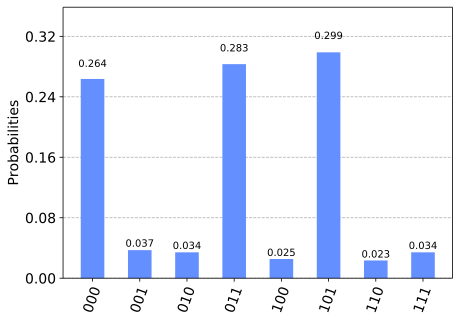

In [6]:
plot_histogram(result['measurement'])

シミュレーターが例題の解を見つけられることを確認しました。ノイズと不完全なゲートを持つ本物の量子デバイスを使用したとき、何が起こるか見てみましょう。

ただし、ネットワークを介して実装置に送信できる文字列の長さの制限（この回路のQASMは6万文字以上あります）があるため、上記の回路を実装置のバックエンドで実行することはできません。以下のように、実装置の`ibmq_16_melbourne`バックエンド上でコンパイルしたQASMを表示することはできます：

In [7]:
# Load our saved IBMQ accounts and get the ibmq_16_melbourne backend
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_16_melbourne')

In [8]:
from qiskit.compiler import transpile

# transpile the circuit for ibmq_16_melbourne
grover_compiled = transpile(result['circuit'], backend=backend, optimization_level=3)

print('gates = ', grover_compiled.count_ops())
print('depth = ', grover_compiled.depth())

gates =  OrderedDict([('cx', 366), ('u3', 120), ('u2', 79), ('u1', 74), ('measure', 3), ('barrier', 2)])
depth =  408


必要とされるゲート数は、現在の短期量子コンピュータのデコヒーレンス時間に関する制限をはるかに上回ります。 つまり、充足問題や他の最適化問題を解決するGrover探索の量子回路を設計することはまだ難しいのです。

## 4. 演習問題 <a id='problems'></a>

1. Qiskit Aquaを使用して、次の3-SAT問題を解いてください： $f(x_1, x_2, x_3) = (x_1 \vee x_2 \vee \neg x_3) \wedge (\neg x_1 \vee \neg x_2 \vee \neg x_3) \wedge (\neg x_1 \vee x_2 \vee x_3)$ 。 結果は期待したものでしたか？


## 5. 参考文献 <a id='references'></a>

1. Giacomo Nannicini (2017), "An Introduction to Quantum Computing, Without the Physics", [arXiv:1708.03684 ](https://arxiv.org/abs/1708.03684)

In [9]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.11.1',
 'qiskit-aer': '0.3.4',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.4.5',
 'qiskit-aqua': '0.6.2',
 'qiskit': '0.14.1'}